In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import date, datetime, timedelta
sns.set_theme(style="ticks")
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['mathtext.it'] = 'Arial:italic'

# parameters

In [2]:
yeari, yearf = '2024', '2024'
weeki, weekf = '18', '31'

In [3]:
di = datetime.strptime(f'{yeari}-{weeki}-1', "%Y-%W-%w").date()
df = datetime.strptime(f'{yearf}-{weekf}-1', "%Y-%W-%w").date() + timedelta(6)
ds = [di+timedelta(dt) for dt in range((df-di).days+1)]
daylist = ds
print(di, 'until', df)

2024-04-29 until 2024-08-04


In [4]:
cdef = 'tl7_10m'# 'tl5_10m' 'tl6_10m' 'tl7_10m' 'tl8_10m' 'tl8_60m'
cdef_alt = '16m_10min'# tl5: 62 ... tl7: 16   tl8: 8

# load data

In [5]:
# load stadium meta data
stadname_data = pd.read_csv('data/metadata/stadname_data.csv')
aid2name = {aid: name for aid, name in zip(stadname_data.area_id, stadname_data.area_name)}

aid2city = {aid: city for aid, city in sorted({
    1: 'München',
    2: 'Berlin',
    3: 'Leipzig',
    4: 'Frankfurt am Main',
    10: 'Dortmund',
    11: 'Stuttgart',
    15: 'Köln',
    24: 'Düsseldorf',
    25: 'Hamburg',
    28: 'Gelsenkirchen',

    16: 'Berlin',
    29: 'Hamburg',
    41: 'München',
    64: 'Frankfurt am Main',
}.items(), key=lambda item: item[1])}
city2aid = {city: aid for aid, city in [(aid, city) for aid, city in aid2city.items()][::-1]}

In [6]:
# n_c Germany & stadiums: load total contact numbers for Germany and stadiums
data_germany = pd.read_csv(f'data/fig2/ncontacts_germany_{cdef}.csv')
data_germany['day'] = [d.date() for d in pd.to_datetime(data_germany.day)]
data_germany = data_germany.drop(columns=['resolution','contacts_nonunique','contacts_nonunique_stadium'])\
           .rename(columns={'contacts_unique':'ncontacts_1','contacts_unique_stadium':'ncontacts_2'})

# n_c cities: load total contact numbers numbers for cities
data = pd.read_csv(f'data/fig2/ncontacts_cities_{cdef}.csv')# _2
data['day'] = [d.date() for d in pd.to_datetime(data.day)]
data = data.drop(columns=['resolution','event','contacts_nonunique','contacts_nonunique_stadium'])\
           .rename(columns={'contacts_unique':'ncontacts_1','contacts_unique_stadium':'ncontacts_2'})

# n_pop cities & stadiums: load stadium capacity data for EURO 2024
stadium_data = pd.read_csv('output/00_stadium_data.csv')

# n_d Germany: load did numbers for Germany
panel_data_germany = pd.read_csv('output/00_panel_data_germany.csv')
panel_data_germany['day'] = [d.date() for d in pd.to_datetime(panel_data_germany.day)]

data_germany = data_germany.merge(panel_data_germany, on='day')

# n_d cities: load did numbers for cities
panel_data = pd.read_csv('output/00_panel_data.csv')
panel_data = panel_data.merge(stadium_data[['city','population']])
panel_data['pdid'] = panel_data.ndids / panel_data.population

# n_d stadiums: load did numbers for stadiums
panelstad_data2 = pd.read_csv('output/00_panelstad_data2.csv')
panelstad_data2['day'] = [d.date() for d in pd.to_datetime(panelstad_data2.day)]

# n_p cities: load ping numbers per did for cities
data_pingfreq = pd.read_csv('output/00_data_pingfreq.csv')
#data_pingfreq['fpingsperdid'] = data_pingfreq.npingsperdid / 144.
data_pingfreq = data_pingfreq.rename(columns={'ndids':'ndids_wo_inactive'})
data_pingfreq = panel_data[['city','ndids']].drop_duplicates().merge(data_pingfreq[['city','ndids_wo_inactive','npings']], on='city')
# wo_inactive removes dids on days they are inactive (no pings), therefore higher ping rate that when they are included
data_pingfreq['npingsperdid_wo_inactive'] = data_pingfreq.npings / data_pingfreq.ndids_wo_inactive
data_pingfreq['npingsperdid'] = data_pingfreq.npings / data_pingfreq.ndids / ((df-di).days + 1)
data_pingfreq['fpingsperdid_wo_inactive'] = data_pingfreq.npingsperdid_wo_inactive / (1440. / 10.)
data_pingfreq['fpingsperdid'] = data_pingfreq.npingsperdid / (1440. / 10.)

# load mass event data
match_data = pd.read_csv('output/00_event_data.csv')
match_data['day'] = [d.date() for d in pd.to_datetime(match_data.day)]
match_data['capacity'] = [float(cap) if cap!='auto' else cap for cap in match_data.capacity]

In [7]:
vac_data = [
    ['Berlin', date(2024,7,18), date(2024,8,30)],
    ['Dortmund', date(2024,7,8), date(2024,8,20)],
    ['Düsseldorf', date(2024,7,8), date(2024,8,20)],
    ['Frankfurt am Main', date(2024,7,15), date(2024,8,23)],
    ['Gelsenkirchen', date(2024,7,8), date(2024,8,20)],
    ['Hamburg', date(2024,7,18), date(2024,8,28)],
    ['Köln', date(2024,7,8), date(2024,8,20)],
    ['Leipzig', date(2024,6,20), date(2024,8,2)],
    ['München', date(2024,7,29), date(2024,9,9)],
    ['Stuttgart', date(2024,7,25), date(2024,9,7)],
]
vac_data = pd.DataFrame(vac_data, columns=['city','day_start','day_end'])
#vac_data

# analyses

In [8]:
def match2event(match):
    if '-' in match and len(match)==7:
        event = match
    else:
        mapping = {
            'R Kaiser': 'Roland Kaiser',
            'P Maffay': 'Peter Maffay',
            'A Gabalier': 'Andreas Gabalier',
            'T Swift': 'Taylor Swift',
            'T Scott': 'Travis Scott',
            'H Carpendale': 'Howard Carpendale',
            'M M-Westernhagen': 'Marius Müller Westernhagen',
            'Death Punch': 'Five Finger Death Punch',
            'B Ceylan': 'Bülent Ceylan',
            'A Rieu': 'Andre Rieu',
            'Stadtfest': 'Leipzig Stadtfest',
            'Weinfest': 'Leipzig Weinfest',
            'Hafengeburtstag': 'Hamburg Hafengeburtstag',
            'Rundfunk Open Air': 'Berliner Rundfunk Open Air',
            'CSD': 'Christopher Street Day',
            'BLiga': 'Bundesliga',
            'BLiga rel': 'Bundesliga relegation',
            'UEFA CL': 'UEFA Champions League',
            'Am. Football': 'American football'
        }
        if match in mapping:
            event = mapping[match]
        else:
            event = match
    return event

In [9]:
match_rank = match_data\
                .merge(panel_data[['city','pdid','ndids']], on='city', how='left')\
                .merge(stadium_data[['area_id','population']], on='area_id', how='left')\
                .merge(data[['day','city','ncontacts_2']], on=['day','city'], how='left')\
                .merge(data[['day','city','ncontacts_1']].groupby(['day','city']).sum().reset_index(), on=['day','city'], how='left')\
                .merge(panelstad_data2, on=['day','area_id'], how='left', suffixes=('','_stad'))\
                .merge(data_pingfreq[['city','fpingsperdid']], on='city')\
                .drop_duplicates()
match_rank['pdid_stad'] = match_rank.ndids_stad / match_rank.capacity
match_rank

,day,city,area_id,match,is_football,capacity,pdid,ndids,population,ncontacts_2,ncontacts_1,ndids_stad,fpingsperdid,pdid_stad
0,2024-06-14,München,1,GER-SCO,True,66000.0,0.00095,1399,1472000.0,26.0,246.0,36.0,0.147995,0.000545
2,2024-06-20,München,1,SVN-SRB,True,66000.0,0.00095,1399,1472000.0,6.0,306.0,17.0,0.147995,0.000258
4,2024-06-25,München,1,DEN-SRB,True,66000.0,0.00095,1399,1472000.0,14.0,300.0,23.0,0.147995,0.000348
6,2024-06-17,München,1,ROU-UKR,True,66000.0,0.00095,1399,1472000.0,4.0,268.0,16.0,0.147995,0.000242
8,2024-07-02,München,1,ROU-NED,True,66000.0,0.00095,1399,1472000.0,8.0,306.0,28.0,0.147995,0.000424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2024-06-02,Leipzig,-1,Stadtfest,False,auto,0.00532,3128,NaN,0.0,884.0,NaN,0.173021,NaN
295,2024-05-19,Leipzig,-1,Weinfest,False,auto,0.00532,3128,NaN,0.0,1114.0,NaN,0.173021,NaN
296,2024-05-08,Leipzig,-1,Apache 207,False,auto,0.00532,3128,NaN,0.0,1706.0,NaN,0.173021,NaN
297,2024-06-06,Leipzig,-1,A Rieu,False,auto,0.00532,3128,NaN,0.0,1374.0,NaN,0.173021,NaN


In [10]:
expo_city_p, expo_city_q = 1.0093, 2.2252#0.9422, 3.5642
expo_stad_p, expo_stad_q = 1.4469, 1.0844#1.5769, 0.4554# for tl7 10min   1.1038, 1.5373# for tl8 60min

In [11]:
print(f'expo_city_p: {expo_city_p}, expo_city_q: {expo_city_q}')
print(f'expo_stad_p: {expo_stad_p}, expo_stad_q: {expo_stad_q}')

match_rank['ncontacts_1'] = match_rank.ncontacts_1 / match_rank.ndids / match_rank.fpingsperdid**(expo_city_q) # / match_rank.pdid**(expo_city_p-1.)

ncthr = 20
match_rank['ncontacts_2'] = [n if n>=ncthr else np.nan for n in match_rank.ncontacts_2]
match_rank['ncontacts_2'] = match_rank.ncontacts_2 / match_rank.ndids_stad / (1e-16+match_rank.pdid_stad)**(expo_stad_p-1.) / match_rank.fpingsperdid**(expo_city_q)

match_rank = match_rank.merge(data_germany, on='day', how='left', suffixes=('', '_germany'))
match_rank['ncontacts_3'] = match_rank.ncontacts_1_germany / match_rank.ndid_1 / data_pingfreq.fpingsperdid.mean()**(expo_city_q) # / data_germany.pdid_1.mean()

match_rank['event'] = [match2event(match) for match in match_rank.match]
match_rank_aux = match_rank.copy(deep=True)
match_rank = match_rank[['city','event','ncontacts_2','ncontacts_1','ncontacts_3']]
logscaleboo = False
if logscaleboo:
    match_rank.loc[:,'ncontacts_1'] = [np.log10(n) if n>0 else np.nan for n in match_rank.ncontacts_1]
    match_rank.loc[:,'ncontacts_2'] = [np.log10(n) if n>0 else np.nan for n in match_rank.ncontacts_2]
    match_rank.loc[:,'ncontacts_3'] = [np.log10(n) if n>0 else np.nan for n in match_rank.ncontacts_3]

expo_city_p: 1.0093, expo_city_q: 2.2252
expo_stad_p: 1.4469, expo_stad_q: 1.0844


In [12]:
to_exclude = ['A Bayern','Bundesliga relegation','American football','test match','RLiga (f)','HLiga','BLiga3','HipHop','S25 Berlin',
              'UEFA Champions League','B2Run','DFB Pokal','friendly match']
to_plot = match_rank[~match_rank.event.isin(to_exclude)].sort_values(['ncontacts_1','ncontacts_2','ncontacts_3'], ascending=False)

In [13]:
class2event = {
    'convention': ['DoKomi','Dogs & Fun'],
    'concert Hard-Rock/Metal': ['AC/DC','Rammstein','Five Finger Death Punch','Metallica'],
    "concert Rock'n'Roll/Pop": ['Peter Maffay','SDP','P!NK','Andre Rieu','Andreas Gabalier','Taylor Swift','Green Day','Coldplay',
                                'Berliner Rundfunk Open Air'],
    'concert Schlager': ['Howard Carpendale','Schlagerfest XXL','Marius Müller Westernhagen','Roland Kaiser','Schlagernacht',
                         'Dortmund OLE'],
    'concert Rap': ['Bushido','Travis Scott','Apache 207'],
    'festival': ['Leipzig Stadtfest','Christopher Street Day','Japan Day','Hamburg Hafengeburtstag','Rheinkirmes','Tollwood',
                 'Leipzig Weinfest','Schalke Tach'],
    'Bundesliga': ['Bundesliga'],
    'comedy': ['Bülent Ceylan','Mario Barth'],
}
event2class = {}
for cl, events in class2event.items():
    for event in events:
        event2class[event] = cl
for event in set(to_plot.event):
    if event not in event2class:
        if 'GER' in event:
            event2class[event] = 'EURO 2024 incl. GER'
        else:
            event2class[event] = 'EURO 2024 excl. GER'
to_plot['event_class'] = to_plot.event.map(event2class)

In [14]:
to_plot2 = to_plot.copy(deep=True)
to_plot2['event'] = to_plot2.event + ' (' + to_plot2.event_class.apply(lambda x: (x if not 'concert' in x else 'concert') if not 'EURO' in x else 'EURO 2024') + ')'
to_plot2

,city,event,ncontacts_2,ncontacts_1,ncontacts_3,event_class
50,Stuttgart,AC/DC (concert),NaN,77.696556,15.690152,concert Hard-Rock/Metal
166,Düsseldorf,Japan Day (festival),NaN,62.698249,17.695368,festival
34,Köln,Christopher Street Day (festival),NaN,61.695512,18.078961,festival
36,Köln,Travis Scott (concert),NaN,61.695512,18.078961,concert Rap
168,Düsseldorf,DoKomi (convention),NaN,61.685064,16.851804,convention
...,...,...,...,...,...,...
153,Gelsenkirchen,Bundesliga (Bundesliga),NaN,NaN,NaN,Bundesliga
176,Düsseldorf,Bundesliga (Bundesliga),NaN,NaN,NaN,Bundesliga
177,Düsseldorf,Bundesliga (Bundesliga),NaN,NaN,NaN,Bundesliga
184,Leipzig,Bundesliga (Bundesliga),NaN,NaN,NaN,Bundesliga


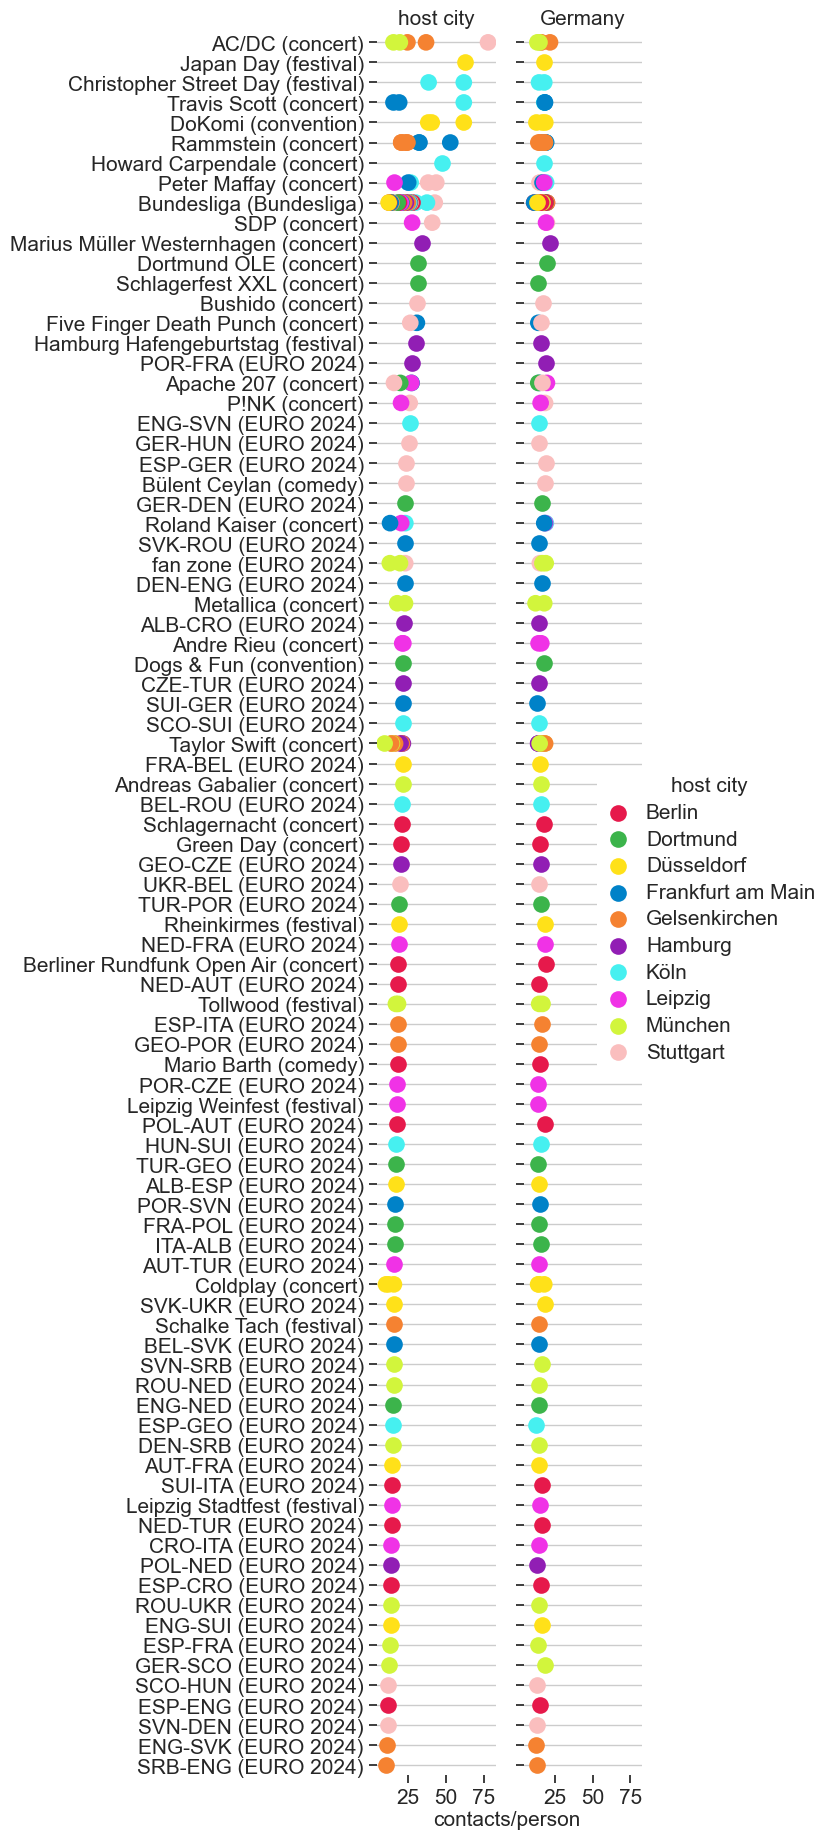

In [15]:
# Make the PairGrid

sns.set_theme(style="ticks")
#to_plot2 = to_plot#[to_plot.event.isin(list(set(to_plot.event.iloc[:(to_plot.event=='Andreas Gabalier').tolist().index(True)+1].tolist())))].copy(deep=True)
g = sns.PairGrid(to_plot2,
                 x_vars=['ncontacts_1','ncontacts_3'], y_vars=["event"],
                 height=18.5, aspect=.1)#12.5, .15

high_contrast_10 = [
    "#e6194b",  # red
    "#3cb44b",  # green
    "#ffe119",  # yellow
    "#0082c8",  # blue
    "#f58231",  # orange
    "#911eb4",  # purple
    "#46f0f0",  # cyan
    "#f032e6",  # magenta
    "#d2f53c",  # lime
    "#fabebe",  # pinkish-light
]

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=12, orient="h", jitter=False,# alpha=.5,
      linewidth=0, edgecolor="w", hue=to_plot2['city'], hue_order=sorted(set(list(aid2city.values()))),
      palette=high_contrast_10)#sns.hls_palette(len(set(match_data.city))))# palette="flare_r", husl/hls_palette

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="contacts", ylabel="")

# Use semantically meaningful titles for the columns
#titles = ["log10(contacts/person host stadium)", "log10(contacts/person host city)", "log10(contacts/person Germany)"]
titles = ["", "contacts/person"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    #ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

# Access the axes and set properties per column
xmin = -5.+min(to_plot[to_plot.ncontacts_1>0].ncontacts_1.min(), #to_plot[to_plot.ncontacts_2>0].ncontacts_2.min(),
           to_plot[to_plot.ncontacts_2>0].ncontacts_3.min())
xmax = 5.+max(to_plot.ncontacts_1.max(), to_plot.ncontacts_3.max()) #to_plot.ncontacts_2.max(),
dx = 0.#5.
titles_top = ['host city', 'Germany']
for i, ax_col in enumerate(g.axes):
    for j, (ax, title) in enumerate(zip(ax_col, titles_top)):
        # Example: Set specific properties per column
        if j == 0:  # First column (x-axis)
            ax.set_xlim([max(0,xmin)-dx, xmax+dx])
            ax.set_ylabel('event')
            ax.set_xlabel(titles[0], fontsize=15)
        elif j == 1:
            ax.set_xlim([max(0,xmin)-dx, xmax+dx])
            ax.set_xlabel(titles[1], fontsize=15)
        ax.set_title(title, fontsize=15)

g.add_legend(title='host city')
sns.despine(left=True, bottom=True)
g.axes.flat[-1].xaxis.set_label_coords(-.14, -.02)#(-.14, -.03)
g.axes.flat[0].set_ylabel('')
for axx in g.axes.flat:
    axx.tick_params(axis='both', labelsize=15)

leg = g._legend#g.add_legend(fontsize=15, title_fontsize=15)
# Change legend fontsize
for text in leg.texts:
    text.set_fontsize(15)          # legend labels
leg.get_title().set_fontsize(15)   # legend title fontsize
leg.set_frame_on(True)
leg.get_frame().set_alpha(1.)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_linewidth(0.)

plt.savefig(f'plots/fig3/eventcmp_horvitz_complete.jpg', bbox_inches='tight', dpi=300)
plt.savefig(f'plots/fig3/eventcmp_horvitz_complete.pdf', bbox_inches='tight')
plt.show()

- GER-DEN: rainfall https://www.welt.de/sport/fussball/em/article252271302/Deutschland-Daenemark-Diese-Bilder-gingen-um-die-Welt.html
- ENG-NED: rainfall https://www.sportschau.de/fussball/uefa-euro-2024/regenfaelle-in-dortmund-vor-em-halbfinale,regen-dortmund-100.html
- ROM-UKR: demo https://www.br.de/nachrichten/bayern/emotionaler-em-auftakt-fuer-die-ukraine-in-muenchen,UFy5LuC
- TUR-GEO: rainfall https://www.welt.de/sport/fussball/em/article252096768/Tuerkei-Georgien-Das-bislang-groesste-Spektakel-der-EM-2024.html
- ENG-SRB: riot https://www.welt.de/sport/fussball/em/article252059140/EM-2024-Vor-dem-Spiel-geraten-Fans-von-England-und-Serbien-aneinander.html
- all Gelsenkirchen matches after ENG-SRB except ENG-SLO: fear of riot https://uefaeuro2024.gelsenkirchen.de/de/index.aspx
- DEN-ENG: city center crowded https://www.hessenschau.de/panorama/daenemark---england-roemerberg-in-frankfurt-in-britischer-hand-prinz-william-im-stadion-v9,em-frankfurt-frederik-100.html
- SVK-ROM: storm, fan zone visitors sent home https://www.hessenschau.de/panorama/em-fanmeile-in-frankfurt-wegen-unwetter-geschlossen-v2,kurz-frankfurt-fanmeile-geschlossen-unwetter-100.html
- FRA-BEL: fan march https://www1.wdr.de/nachrichten/rheinland/duesseldorf-em-fanmaersche-belgien-frankreich-100.html
- ALB-ESP: mobile data record https://rp-online.de/sport/fussball/em/fussball-em-2024-datenrekord-bei-spanien-gegen-albanien-in-duesseldorfer-arena_aid-115042555